In [18]:
# import libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import scipy.stats as stats
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

import os


# Data Analysis

In [19]:
df = pd.read_csv('Data/healthcare-dataset-stroke-data.csv')
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [20]:
df.dtypes

id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [21]:
df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [22]:
df['bmi']=df['bmi'].fillna(np.mean(df['bmi']))

In [23]:
pd.DataFrame({"number of null values":df.isna().sum()})

,number of null values
id,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
work_type,0
Residence_type,0
avg_glucose_level,0
bmi,0


In [24]:
# drope id column as a column without effective information

df.drop("id", axis=1, inplace=True)
print(df.shape)
df.head(5)
pa = df.loc[df['stroke'] == 1]
pa.shape


(5110, 11)


(249, 11)

In [25]:
cat_var = ["gender", "ever_married", "work_type", "Residence_type", "smoking_status"]
for i in cat_var:
    print("\nFeature: %s \n" % (i))
    print(df[i].value_counts())
    


Feature: gender 

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

Feature: ever_married 

Yes    3353
No     1757
Name: ever_married, dtype: int64

Feature: work_type 

Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

Feature: Residence_type 

Urban    2596
Rural    2514
Name: Residence_type, dtype: int64

Feature: smoking_status 

never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64


In [26]:
# Gender
df.drop(df[df.gender == 'Other'].index, axis = 0, inplace=True)
data_copy = df.copy()

# Dummy Encoding
dummy_df = pd.get_dummies(df.iloc[:, [0, 4, 6]], drop_first=True)
df['gender'] = dummy_df.iloc[:, 0]
df['ever_married'] = dummy_df.iloc[:, 1]
df['Residence_type'] = dummy_df.iloc[:, 2]

# Frequency Encoding
freq_smoking = (df.groupby('smoking_status').size()) / len(df)
freq_smoking['Unknown'] = 0 
df['smoking_status'] = df['smoking_status'].apply(lambda x : freq_smoking[x])

freq_work = (df.groupby('work_type').size()) / len(df)
df['work_type'] = df['work_type'].apply(lambda x : freq_work[x])
data= df
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,0.572323,1,228.69,36.600000,0.173028,1
1,0,61.0,0,0,1,0.160305,0,202.21,28.893237,0.370327,1
2,1,80.0,0,1,1,0.572323,0,105.92,32.500000,0.370327,1
3,0,49.0,0,0,1,0.572323,1,171.23,34.400000,0.154433,1
4,0,79.0,1,0,1,0.160305,0,174.12,24.000000,0.370327,1


## Scaling the data

In [27]:
upper_fence_age = data["age"].mean() + 3*data["age"].std()
lower_fence_age = data["age"].mean() - 3*data["age"].std()
print("Highest allowed: ", upper_fence_age)
print("Lowest allowed: ", lower_fence_age)
outliers_age = data[(data["age"] > upper_fence_age) | (data["age"] < lower_fence_age)]
print(outliers_age.shape[0])

print("avg_glucose_level")
upper_fence_glucose = data["avg_glucose_level"].mean() + 3*data["avg_glucose_level"].std()
lower_fence_glucose = data["avg_glucose_level"].mean() - 3*data["avg_glucose_level"].std()
print("Highest allowed",upper_fence_glucose)
print("Lowest allowed", lower_fence_glucose)
outliers_glucose = data[(data["avg_glucose_level"] > upper_fence_glucose) | (data["avg_glucose_level"] < lower_fence_glucose)]
print(outliers_glucose.shape[0])

print("bmi")
upper_fence_bmi = data["bmi"].mean() + 3*data["bmi"].std()
lower_fence_bmi = data["bmi"].mean() - 3*data["bmi"].std()
print("Highest allowed: ", upper_fence_bmi)
print("Lowest allowed: ", lower_fence_bmi)
outliers_bmi = data[(data["bmi"] > upper_fence_bmi) | (data["bmi"] < lower_fence_bmi)]
print(outliers_bmi.shape[0])

Highest allowed:  111.07071222164141
Lowest allowed:  -24.610739624264212
0
avg_glucose_level
Highest allowed 241.99541029257045
Lowest allowed -29.71461170184851
49
bmi
Highest allowed:  51.98921322355169
Lowest allowed:  5.799802481780482
59


In [28]:
outliers = pd.concat([outliers_glucose,outliers_bmi]).drop_duplicates()
data.drop(outliers.index, axis=0, inplace=True)

In [29]:
scaler = MinMaxScaler()
data[["age", "avg_glucose_level", "bmi"]] = scaler.fit_transform(data[["age", "avg_glucose_level", "bmi"]])
data.head(3)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,0.816895,0,1,1,0.572323,1,0.934478,0.632212,0.173028,1
1,0,0.743652,0,0,1,0.160305,0,0.791913,0.446953,0.370327,1
2,1,0.975586,0,1,1,0.572323,0,0.273501,0.533654,0.370327,1


In [30]:
# summarize the number of rows with missing values for each column, doublec check 
for i in range(data.shape[1]):
    n_miss = data.iloc[:, i].isnull().sum()
    perc = n_miss / data.shape[0] * 100
    print('> %s, Missing: %d (%.1f%%)' % (data.columns[i], n_miss, perc))

> gender, Missing: 0 (0.0%)
> age, Missing: 0 (0.0%)
> hypertension, Missing: 0 (0.0%)
> heart_disease, Missing: 0 (0.0%)
> ever_married, Missing: 0 (0.0%)
> work_type, Missing: 0 (0.0%)
> Residence_type, Missing: 0 (0.0%)
> avg_glucose_level, Missing: 0 (0.0%)
> bmi, Missing: 0 (0.0%)
> smoking_status, Missing: 0 (0.0%)
> stroke, Missing: 0 (0.0%)


In [31]:
# data shape
data.loc[data.stroke == 1].shape[0]

239

In [32]:
data.loc[(data.bmi.isna() == True) & (data.stroke == 1)].shape[0]

0

In [33]:
imputer = KNNImputer(n_neighbors=5)
data = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)
data.isna().any()

gender               False
age                  False
hypertension         False
heart_disease        False
ever_married         False
work_type            False
Residence_type       False
avg_glucose_level    False
bmi                  False
smoking_status       False
stroke               False
dtype: bool

# Exploratory Data Analysis (EDA)

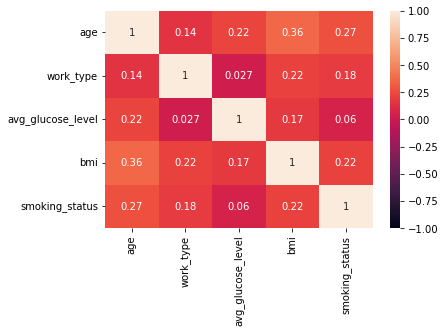

In [34]:
# Pearson correlations 

sns.heatmap(data[["age", 'work_type', 'avg_glucose_level', 'bmi', 'smoking_status']].corr(), vmin=-1, vmax=1, annot=True)
plt.savefig('pearsons.png', bbox_inches='tight')

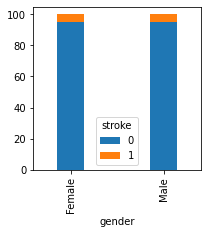

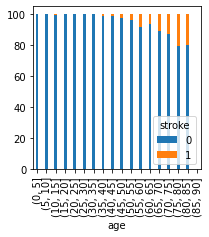

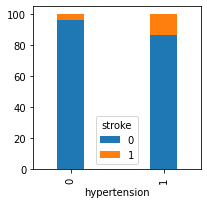

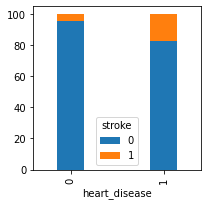

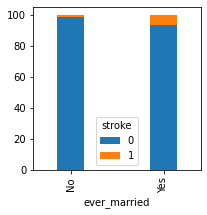

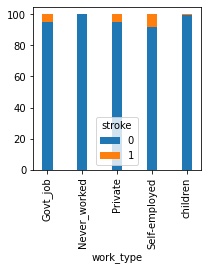

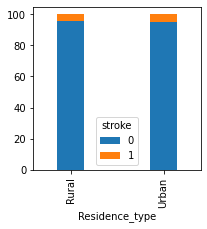

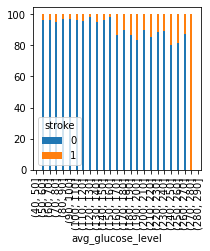

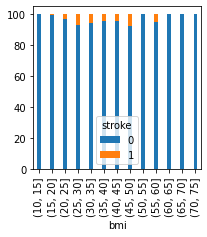

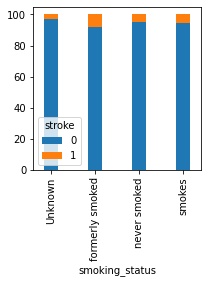

In [35]:
def get_100_percent_stacked_bar_chart(column, width = 0.3):
    # Get the count of records by column and stroke
    df_breakdown = data_copy.groupby([column, 'stroke'])['age'].count()
    # Get the count of records by the column
    df_total = data_copy.groupby([column])['age'].count()
    # Get the percentage for 100% stacked bar chart
    df_pct = df_breakdown / df_total * 100
    # Create proper DataFrame's format
    df_pct = df_pct.unstack()
    return df_pct.plot.bar(stacked=True, figsize=(3,3), width=width);

# discretisize the features
data_copy['age'] = pd.cut(data_copy['age'], np.arange(0, 91, 5))
data_copy['bmi'] = pd.cut(data_copy['bmi'], np.arange(10, 80, 5))
data_copy['avg_glucose_level'] = pd.cut(data_copy['avg_glucose_level'], np.arange(40, 300, 10))

for i in data_copy.columns[:-1]:
    get_100_percent_stacked_bar_chart(i)

In [36]:
table = data_copy.groupby("hypertension").sum().values
oddsratio, pvalue = stats.fisher_exact(table)
print("hypertension: \n")
print("OddsR: ", oddsratio, "p-Value:", pvalue)

table = data_copy.groupby("heart_disease").sum().values
oddsratio, pvalue = stats.fisher_exact(table)
print("\nheart disease: \n")
print("OddsR: ", oddsratio, "p-Value:", pvalue)

hypertension: 

OddsR:  1.194672131147541 p-Value: 0.41821936982180613

heart disease: 

OddsR:  1.5778155940594059 p-Value: 0.03772449849987167


# Modelling   

##  1. Decision Tree

In [37]:
X_train = data.drop('stroke', axis=1)
y_train = data.iloc[:, -1]

In [38]:
random_state = 77
kfold = StratifiedKFold(n_splits=10)
classifiers = []
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(SVC(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())

In [39]:
cv_means

[0.9150179640718564,
 0.9522095808383234,
 0.9522095808383234,
 0.9170167664670659,
 0.9512099800399202,
 0.9506091816367265,
 0.9488107784431138]

In [40]:
# Random Forest

RFC = RandomForestClassifier()
rf_param_grid = {"max_depth": [None],
              "max_features": [3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini", "entropy"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose=1)

gsRFC.fit(X_train,y_train)

RFC_best = gsRFC.best_estimator_
gsRFC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


0.9522095808383234

In [41]:
def plot_learning_curve(estimator, title, X, y, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

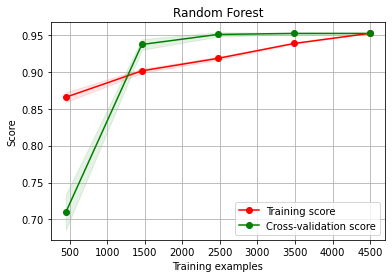

In [42]:
rf = plot_learning_curve(RFC_best, "Random Forest", X_train,y_train, cv=kfold)
plt.savefig('RF.png', bbox_inches='tight')